# Análisis Dataset de "Inside Airbnb" : ESTAMBUL


<center><img src="https://www.miladoviajero.com/wp-content/uploads/Estambul-mapa.jpg"></center>

# 1. Introducción

"Inside Airbnb" es un sitio web que publica información sobre los alojamientos que se encuentran rentados bajo la plataforma de plataforma Airbnb. Esta web busca mostrar el impacto que tiene esta plataforma en el mercado de la vivienda para cada ciudad.
Hemos decidido seleccionar la ciudad de Estambul. Se etrajeron 7 Dataset, 2 con información de las vivendas rentadas y sus propietarios, 2 con datos del vecindario , 2 con las reviews y uno con el calandario.

1.- ¿La ubicación es importante para el huésped?
2.- ¿El tipo de habitación es importante para el huésped?
3.- ¿Un tiempo de respuesta se relaciona con más reservas?
4.- ¿Al usuario parece importarle que el host tenga la calificación de superhost?

# 2. Librerias

In [64]:
import numpy as np
import pandas as pd


#to make graphs
import matplotlib.pyplot as plt
import seaborn as sns

#to make the plotly graphs
import plotly.graph_objs as go
import plotly.express as px

#to make maps
import geopandas as gpd

# warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [63]:
!pip install geopandas

     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     --------------- ------------------------ 0.4/1.1 MB 8.7 MB/s eta 0:00:01
     ---------------------------------------  1.1/1.1 MB 13.8 MB/s eta 0:00:01
     ---------------------------------------- 1.1/1.1 MB 9.9 MB/s eta 0:00:00
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     -------------- ------------------------- 2.0/5.7 MB 65.4 MB/s eta 0:00:01
     --------------------------- ------------ 3.9/5.7 MB 50.3 MB/s eta 0:00:01
     ---------------------------------------  5.7/5.7 MB 52.1 MB/s eta 0:00:01
     ---------------------------------------  5.7/5.7 MB 52.1 MB/s eta 0:00:01
     ---------------------------------------- 5.7/5.7 MB 30.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
     ---------------------------------------  1.4/1.4 MB 84.5 MB/s eta 0:00:01
     ---------------------------------------- 1.4/1.4 MB 28.9 MB/s eta 0:00:00


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\fabia\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import plotly.express as px

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

ModuleNotFoundError: No module named 'folium'

# 3. Read Datasets

## 3.1 Detalles del listado de viviendas

* El conjunto de datos contiene un total de 7 archivos. 
* El archivo de listados es un archivo de descripción general que las etiquetas internas de airbnb como "bueno para visualizaciones". 
* El identificador único en el conjunto de datos es la identificación de "listings". Esta es básicamente la identificación del anuncio. 


### Lectura de los datasets

In [2]:
listings = pd.read_csv("data/listings.csv", index_col= "id")
listings_details = pd.read_csv("data/listings_details.csv", index_col= "id", low_memory=False)

calendar = pd.read_csv('data/calendar.csv', parse_dates=['date'], index_col=['listing_id']).reset_index()
reviews_details = pd.read_csv("data/reviews_details.csv", parse_dates=['date']).reset_index()
neighbourhoods = pd.read_csv("data/neighbourhoods.csv").reset_index()

# 4. Limpieza de Datos

### Funciones de análisis

In [3]:
def reporte (df):   
    
    """ Esta función recibe un df y nos imprime un reporte inicial del df"""
    
    print('El df esta formado por: ', df.shape[0], 'filas y', df.shape[1], 'columnas')
    print('Cantidad de valores duplicados: ',df.duplicated().sum())
    print('Cantidad de valores nulos: ', df.isnull().sum().sum())
    # print('Primeras filas del df:')
    # return df.head(3) # Imprimimos las primeras filas para ver las columnas y asi tener una primera vista de lo que hay en el df

In [4]:
def percentage_null (df):
    missing_data = pd.isnull(df).sum()
    missing_data_percentage = missing_data/len(df)*100 #Calculamos el % del los datos faltantes en cada columna
    nulos_totales= missing_data_percentage.sort_values(ascending = False) #Ordenamos de mayor a menor
    nulos_totales = pd.DataFrame(nulos_totales,columns=["% nulos"])
    return nulos_totales.round(2)

## 4.1 Dataset: listings

#### Contenido de las columnas

* ***id***: Airbnb's unique identifier for the listing
* ***name***: Name of the listing
* ***host_id***: Airbnb's unique identifier for the host/user
* ***host_name***: Name of the host. Usually just the first name(s).
* ***neighbourhood_group***: The neighbourhood group as geocoded using the latitude and longitude against neighborhoods as defined by open or public digital shapefiles.
* ***neighbourhood***: The neighbourhood as geocoded using the latitude and longitude against neighborhoods as defined by open or public digital shapefiles.
* ***latitude***: Uses the World Geodetic System (WGS84) projection for latitude and longitude.
* ***longitude***: Uses the World Geodetic System (WGS84) projection for latitude and longitude.
* ***room_type***: All homes are grouped into the following three room types: 1. Entire home/apt 2. Private room 3. Shared room|Hotel]
* ***price***: daily price in local currency. Note, $ sign may be used despite locale
* ***minimum_nights***: minimum number of night stay for the listing (calendar rules may be different)
* ***number_of_reviews***: The number of reviews the listing has
* ***last_review***: The date of the last/newest review
* ***calculated_host_listings_count***: The number of listings the host has in the current scrape, in the city/region geography.
* ***availability_365***: avaliability_x. The availability of the listing x days in the future as determined by the calendar. Note a listing may be available because it has * been booked by a guest or blocked by the host.
* ***number_of_reviews_ltm***: The number of reviews the listing has (in the last 12 months)
* ***license***: The licence/permit/registration number


### Informe inicial

In [5]:
# Usamos esta función para tener en un solo informe que es lo que tenemos en nuestro df
reporte(listings)

El df esta formado por:  41501 filas y 17 columnas
Cantidad de valores duplicados:  8
Cantidad de valores nulos:  118101


## 4.2 Dataset: listings_details

### Informe inicial

In [6]:
reporte(listings_details)

El df esta formado por:  41501 filas y 74 columnas


Cantidad de valores duplicados:  0
Cantidad de valores nulos:  503873


Dado que el este data frame tiene 74 columnas seleccionamos las columnas que necesitamos para nuestro analisis.
Cremaos la variable columnas con un total de 19 variables que hemos seleccionado para nuestro análisis.


In [7]:
columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "host_listings_count","number_of_reviews_ltm","reviews_per_month"]

## 4.3 Merge : listings & listings_details

In [8]:
df = pd.merge(listings, listings_details[columns], on='id', how='left')

In [9]:
reporte(df)

El df esta formado por:  41501 filas y 36 columnas
Cantidad de valores duplicados:  0
Cantidad de valores nulos:  321467


### Eliminación de columnas con valores nulos

In [10]:
# Vemos el % de columnas con valores nulos
percentage_null(df).T

,license,neighbourhood_group,host_about,review_scores_checkin,review_scores_location,review_scores_value,review_scores_communication,review_scores_accuracy,review_scores_cleanliness,reviews_per_month_y,...,longitude,host_id,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm_x,accommodates
% nulos,100.0,100.0,59.65,42.55,42.55,42.55,42.55,42.55,42.55,42.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Las columnas license y neighbourhood_group presentan un 100% de porcentaje nulos se procede a eliminarlas.


In [11]:
# Como las columnas license y neighbourhood_group presentan un 100% de porcentaje nulos se procede a eliminarlas
df = df.drop(columns=['neighbourhood_group','license'])

In [12]:
# La columna host_about es la descripción que hace el host para presentarse, como es una variable que no vamos a utilizar
# procedemos a quiratla de nuestro df.
df = df.drop(columns=['host_about'])

In [13]:
# En la columna name vamos a reemplazar los nulos por la palabra "no_name"
df['name'] = df['name'].fillna("no_name")

Con respecto a resto de las columnas que contienen null y corresponden a reviews no las vamos a reemplazar ya que es mejor trabajar con la información real.

In [14]:
percentage_null(df).T

,review_scores_value,review_scores_location,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_communication,reviews_per_month_y,reviews_per_month_x,last_review,review_scores_rating,...,calculated_host_listings_count,number_of_reviews,minimum_nights,price,room_type,longitude,latitude,neighbourhood,host_name,accommodates
% nulos,42.55,42.55,42.55,42.55,42.55,42.55,42.26,42.26,42.26,42.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tranformación de columnas

In [15]:
pd.set_option('display.max_columns', None)

In [16]:
# Usamos el método info para ver como estan compuestas nuestras columnas
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 41501 entries, 25436 to 857756437907689464
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            41501 non-null  object 
 1   host_id                         41501 non-null  int64  
 2   host_name                       41501 non-null  object 
 3   neighbourhood                   41501 non-null  object 
 4   latitude                        41501 non-null  float64
 5   longitude                       41501 non-null  float64
 6   room_type                       41501 non-null  object 
 7   price                           41501 non-null  int64  
 8   minimum_nights                  41501 non-null  int64  
 9   number_of_reviews               41501 non-null  int64  
 10  last_review                     23964 non-null  object 
 11  reviews_per_month_x             23964 non-null  float64
 12  calculated_host_list

In [17]:
# Podemos ver que el dtype de las columnas estan correctos por lo que no procedemos a realizar ningun cambio
df['host_response_rate'] = pd.to_numeric(df['host_response_rate'].str.strip('%'))

In [18]:
# Cambiamos el contenido de la columna host_is_superhost a través de un diccionario:
# df['host_is_superhost'] = df['host_is_superhost'].replace({'f': False, 't': True})

In [19]:
df['price_euro'] = df['price']*0.04564 
df['price_euro'] = df['price_euro'].round(2).astype('int64')

In [20]:
# Ahora si imprimimos el head del df con el que vamos a continuar:
df.head()

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month_x,calculated_host_listings_count,availability_365,number_of_reviews_ltm_x,property_type,accommodates,first_review,review_scores_value,review_scores_cleanliness,review_scores_location,review_scores_accuracy,review_scores_communication,review_scores_checkin,review_scores_rating,maximum_nights,listing_url,host_is_superhost,host_response_time,host_response_rate,host_listings_count,number_of_reviews_ltm_y,reviews_per_month_y,price_euro
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25436,In the forest Sea view Two minutes to the city.,105823,Yesim,Besiktas,41.07883,29.03863,Entire home/apt,2085,25,0,NaN,NaN,1,348,0,Entire rental unit,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1125,https://www.airbnb.com/rooms/25436,f,NaN,NaN,1,0,NaN,95
27271,Lovely apartment in perfect location,117026,Mutlu,Beyoglu,41.03254,28.98153,Entire home/apt,1044,10,4,2022-11-01,0.04,1,266,1,Entire rental unit,2,2014-10-20,5.00,4.75,5.00,5.00,5.00,5.00,5.00,90,https://www.airbnb.com/rooms/27271,f,within a day,100.0,1,1,0.04,47
304011,Beyoglu / Central with Beautiful View,1564870,Living,Beyoglu,41.03537,28.97316,Entire home/apt,1118,28,28,2023-03-18,0.26,2,240,7,Entire rental unit,4,2014-05-12,4.63,4.93,4.59,4.85,4.93,4.96,4.67,365,https://www.airbnb.com/rooms/304011,t,within a few hours,90.0,2,7,0.26,51
304029,Zero km to City Center -- Friendly,1564916,Esen,Sisli,41.05156,28.99052,Private room,384,2,36,2023-01-05,0.27,1,94,1,Private room in loft,2,2012-05-07,4.91,4.94,4.79,4.88,5.00,5.00,4.94,10,https://www.airbnb.com/rooms/304029,f,within a few hours,100.0,1,1,0.27,17
28277,Duplex Apartment 11 with Terrace,121607,Alen Ziya,Sisli,41.04672,28.98402,Entire home/apt,1857,10,8,2022-11-26,0.35,20,361,6,Entire serviced apartment,5,2021-05-15,4.75,4.75,5.00,5.00,5.00,4.88,5.00,360,https://www.airbnb.com/rooms/28277,t,within an hour,100.0,20,6,0.35,84


## 4.3 Dataset: calendar

Este Dataframe muestra la disponibiiad que tiene el alojamiento desde el 2023-03-31  al  2024-04-02.

### Informe inicial

In [21]:
reporte(calendar)

El df esta formado por:  15146021 filas y 7 columnas


Cantidad de valores duplicados:  0
Cantidad de valores nulos:  68


In [22]:
calendar.head(3)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,25436,2023-03-31,f,"$2,085.00","$2,085.00",25.0,1125.0
1,25436,2023-04-01,f,"$2,085.00","$2,085.00",25.0,1125.0
2,25436,2023-04-02,f,"$2,085.00","$2,085.00",25.0,1125.0


In [23]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15146021 entries, 0 to 15146020
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 808.9+ MB


In [24]:
calendar['date'] = calendar['date'].dt.date

In [25]:
print('Período de fechas de análisis', calendar['date'].min(), ' - ', calendar['date'].max())

Período de fechas de análisis 2023-03-31  -  2024-04-02


### Eliminación de duplicados

In [26]:
# Eliminamos las filas dulicadas
# calendar = calendar.drop_duplicates()

### Eliminación de columnas con valores nulos

## 4.4 Dataset: reviews_details

### Informe inicial

In [27]:
reporte(reviews_details)

El df esta formado por:  416940 filas y 7 columnas


Cantidad de valores duplicados:  0
Cantidad de valores nulos:  21


### Eliminación de columnas con valores nulos

In [28]:
# Vemos el % de columnas con valores nulos
percentage_null(reviews_details)

,% nulos
comments,0.0
reviewer_name,0.0
index,0.0
listing_id,0.0
id,0.0
date,0.0
reviewer_id,0.0


In [29]:
#  Dado que esta columa presenta valores muy pequeños de nulos se reemplazan por un "no_comments"
reviews_details['comments'] = reviews_details['comments'].fillna("no_comments")

In [30]:
#  Dado que esta columa presenta valores muy pequeños de nulos se reemplazan por un "no_name"
reviews_details['reviewer_name'] = reviews_details['reviewer_name'].fillna("no_name")

## 4.5 Dataset: neighbourhoods

Este dataframe contiene una lista de todos los vecindarios que presenta nuetro dt.


### Informe inicial

In [31]:
reporte(neighbourhoods)

El df esta formado por:  39 filas y 3 columnas
Cantidad de valores duplicados:  0
Cantidad de valores nulos:  39


In [32]:
# Cantidad de vecindarios:
neighbourhoods['neighbourhood'].sort_values().count()

39

In [33]:
neighbourhoods.head()

,index,neighbourhood_group,neighbourhood
0,0,NaN,Adalar
1,1,NaN,Arnavutkoy
2,2,NaN,Atasehir
3,3,NaN,Avcilar
4,4,NaN,Bagcilar


## 4.6 Outliers

### Funciones de análisis y reemplazar outliers:

In [34]:
# Función para encodear
def encodear (df):
    """Esta función recibe un df y realiza en LabelEncode de aquellas variables que estan como: 'object' o 'string'
    Devuelve un df encodeado
    """
    from sklearn.preprocessing import LabelEncoder #Librería
    le = LabelEncoder()
    df_encoded = df.copy()
    for col in df_encoded.columns[df_encoded.dtypes == 'object']:
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    return df_encoded

In [35]:
#Función para ver la cantidad de outliers que hay en un dataset
def outliers (df):
    
    """ La función recibe un df
    y calcula la cantidad de outliers en función del  primer cuartil y segundo cuartil
    y devuelve un print de la cantida de outlier en cada columna"""

    for columnas in df:
        Q1 = df[columnas].quantile(0.25)
        Q3 = df[columnas].quantile(0.75)
        IQR = Q3 - Q1
        outlierIzq = Q1-(1.5*IQR)
        outlierDer = Q3+(1.5*IQR)
        outliers = df[columnas][(df[columnas] < outlierIzq) | (df[columnas] > outlierDer)]
        if len(outliers) >0:
            print("La variable " + columnas + " tiene: " + str(len(outliers)) + " :valores outliers")


In [36]:
def reemplazar_outliers_iqr(df):
    """
    La función recibe un df y reemplaza los outliers del  df usando el método IQR.
    retorna un df con los putlier reemplazados en función del rango intercuartil 
    """
    for columna in df:
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[columna] < (Q1 - 1.5 * IQR)) | (df[columna] > (Q3 + 1.5 * IQR))]
        df[columna] = np.where(df[columna] < (Q1 - 1.5 * IQR), Q1, df[columna])
        df[columna] = np.where(df[columna] > (Q3 + 1.5 * IQR), Q3, df[columna])
    return df.head()

### Encodeado y reemplazado de Outliers

In [37]:
# Procedemos a encodear nuestro df definiedo un nuevo df encodeado:
df_encoded = encodear(df)

In [38]:
# Imprimimos nuestros outiers:
print(outliers(df_encoded))

La variable latitude tiene: 2739 :valores outliers
La variable longitude tiene: 9938 :valores outliers
La variable price tiene: 3185 :valores outliers
La variable minimum_nights tiene: 5734 :valores outliers
La variable number_of_reviews tiene: 5789 :valores outliers
La variable last_review tiene: 4389 :valores outliers
La variable reviews_per_month_x tiene: 1251 :valores outliers
La variable calculated_host_listings_count tiene: 4336 :valores outliers
La variable number_of_reviews_ltm_x tiene: 4949 :valores outliers
La variable property_type tiene: 39 :valores outliers
La variable accommodates tiene: 1500 :valores outliers
La variable first_review tiene: 5059 :valores outliers
La variable review_scores_value tiene: 1605 :valores outliers
La variable review_scores_cleanliness tiene: 1839 :valores outliers
La variable review_scores_location tiene: 2434 :valores outliers
La variable review_scores_accuracy tiene: 2591 :valores outliers
La variable review_scores_communication tiene: 2681 :

<Axes: xlabel='room_type', ylabel='price_euro'>

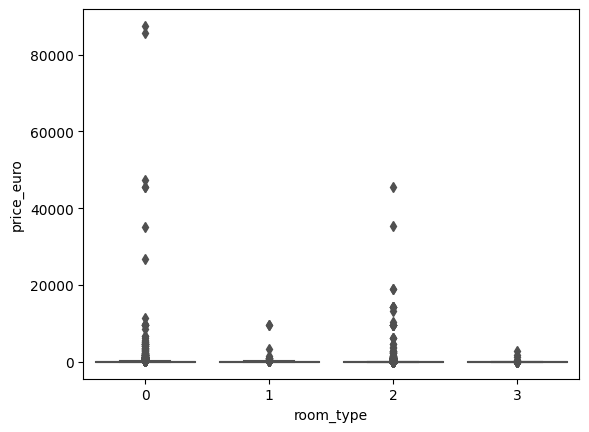

In [39]:
# Graficamos la variable room_type para ver como son sus precios y podemos ver que si hay mucha dispeción.
sns.boxplot(x="room_type", y="price_euro", data=df_encoded,palette='rainbow')

In [40]:
# Reemplazamos todos los outiers:
reemplazar_outliers_iqr(df_encoded)

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month_x,calculated_host_listings_count,availability_365,number_of_reviews_ltm_x,property_type,accommodates,first_review,review_scores_value,review_scores_cleanliness,review_scores_location,review_scores_accuracy,review_scores_communication,review_scores_checkin,review_scores_rating,maximum_nights,listing_url,host_is_superhost,host_response_time,host_response_rate,host_listings_count,number_of_reviews_ltm_y,reviews_per_month_y,price_euro
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25436,18095.0,105823.0,6246.0,9.0,41.07883,29.03863,0.0,2085.0,3.0,0.0,1525.0,NaN,1.0,348.0,0.0,22.0,3.0,2774.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1125.0,1833.0,0.0,1.0,NaN,1.0,0.0,NaN,95.0
27271,21055.0,117026.0,4174.0,12.0,41.03254,28.98153,0.0,1044.0,3.0,4.0,1373.0,0.04,1.0,266.0,1.0,22.0,2.0,2408.0,5.00,4.75,5.00,5.00,5.00,5.00,5.00,90.0,2058.0,0.0,2.0,100.0,1.0,1.0,0.04,47.0
304011,6586.0,1564870.0,3419.0,12.0,41.03537,28.97316,0.0,1118.0,3.0,7.0,1510.0,0.26,2.0,240.0,7.0,22.0,4.0,2408.0,4.63,4.93,4.59,4.85,4.93,4.96,4.67,365.0,2719.0,0.0,3.0,100.0,2.0,7.0,0.26,51.0
304029,34871.0,1564916.0,2006.0,32.0,41.05156,28.99052,2.0,384.0,2.0,7.0,1438.0,0.27,1.0,94.0,1.0,53.0,2.0,2408.0,4.91,4.94,4.79,4.88,5.00,5.00,4.94,10.0,2721.0,0.0,3.0,100.0,1.0,1.0,0.27,17.0
28277,13406.0,121607.0,291.0,32.0,41.04672,28.98402,0.0,1857.0,3.0,8.0,1398.0,0.35,8.0,361.0,6.0,23.0,5.0,2087.0,4.75,4.75,5.00,5.00,5.00,4.88,5.00,360.0,2269.0,0.0,4.0,100.0,8.0,6.0,0.35,84.0


<Axes: xlabel='room_type', ylabel='price_euro'>

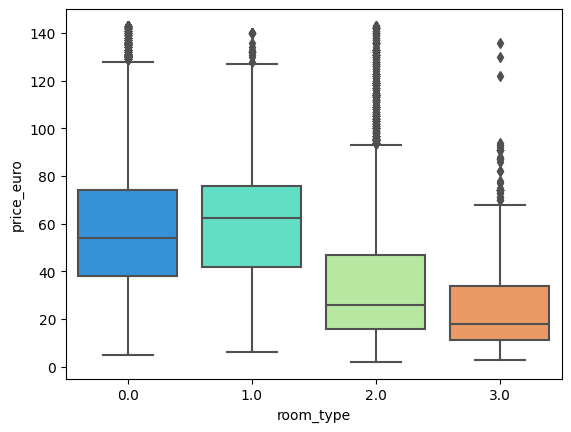

In [41]:
sns.boxplot(x="room_type", y="price_euro", data=df_encoded,palette='rainbow')

# 5. Análisis Exporatorio de Datos

Ahora con nuestro DF limpio procedemos a realizar nuestro análisis exploratorio.


In [43]:
reporte(df)

El df esta formado por:  41501 filas y 34 columnas
Cantidad de valores duplicados:  0
Cantidad de valores nulos:  213686


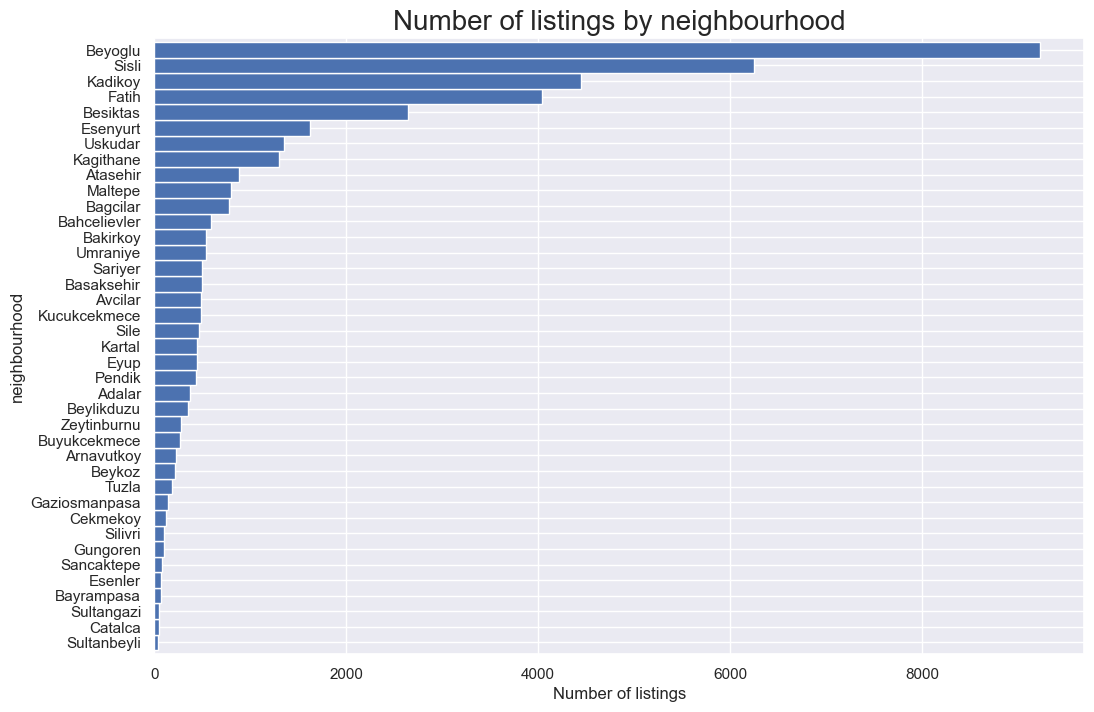

In [46]:
# ¿La ubicación es importante para el huésped?
feq=df['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(12, 8), color='b', width=1)
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

In [61]:
#Plotly version 
px.bar(feq, orientation='h', title = "Number of listings by neighbourhood", template= "plotly_dark")

In [58]:
feq.sort_values(ascending=False).head()

neighbourhood
Beyoglu     9229
Sisli       6254
Kadikoy     4442
Fatih       4036
Besiktas    2649
Name: count, dtype: int64

In [65]:
adam = gpd.read_file("input/neighbourhoods.geojson")
# Asegurarse de que 'feq' es un DataFrame de pandas correcto antes de transponerlo
# Si 'feq' es un DataFrame, no necesitamos encapsularlo en una lista y convertirlo a DataFrame otra vez
feq = feq.transpose()
# Mezclamos
adam = pd.merge(adam, feq, on='neighbourhood', how='left')

# Renombramos la columna
adam.rename(columns={'price': 'average_price'}, inplace=True)

# Redondeamos el precio
adam.average_price = adam.average_price.round(decimals=2)

# Conseguimos colores para nuestras casas 
map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    if value is not None:
        return color_scale(value)
    else:
        return 'grey'  # Un color predeterminado si el barrio no está en el diccionario

# 6. Modelado

## 6.1 normalización de los datos

# 7. Informe